# CENSUS INCOME PREDICTION-MACHINE LEARNING


### Question 1

Considering the Census Income data with response variable as Income(>50k and <=50k).

* Import the csv dataset from [Data Source](https://www.kaggle.com/uciml/adult-census-income)  (1 points).
* Identify the presence of missing values, fill the missing values with mean for numerical attributes and mode value for categorical attributes. (2 points)
* Visualize the dataset. (1 points)
* Extract X as all columns except the Income column and Y as Income column. (1 points)
* Split the data into training set and testing set. (1 points)
* Model the classifier using GaussianNB and MultinomialNB. (2 points)
* Compute the accuracy and confusion matrix for each model. (4 points)
* Plot the decision boundary, visualize training and test results (1 point)

The following steps are performed in a sequencial order to load, explore the data, build the model and evaluation. 

<a id="top"></a>
**Sequential Steps:**
0. [Import Libraries](#import)
1. [Loading data](#loaddata)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#datapreparation)
4. [Building Model](#modelbuilding)
5. [Evaluation of Model](#evaluation)
6. [Decision Boundary](#decisionboundary)

<a id="import"></a>
## Step 0: Importing Required Libraries

In [23]:
#!pip install pandas-profiling sklearn

In [361]:
import pandas as pd
import numpy as np

import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline

plt.style.use('ggplot')

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

<a id="loaddata"></a>

## Step 1: Loading Data 
Move [top](#top)

In [163]:
data = pd.read_csv(na_values='?',filepath_or_buffer='./adult.csv')
data.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90       NaN   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66       NaN  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                NaN  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                NaN      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [165]:
data.profile_report(style={'full_width':True},correlations={'phi_k':True,'cramers':False,'pearson':False,'spearman':False,'kendall':False,'recoded':False})

## Observations
- Dataset has 24 duplicate rows, - which has to be removed

- `native.country` (Categorical) has 583 (1.8%) missing values 
    - *This will be replaced with ode value, as mentioned in the Assignment statement*

- `occupation` (Categorical) has 1843 (5.7%) missing values
    - *This will be replaced with mode value, as mentioned in the Assignment statement*
    - *Top 3 values frequencies are 12.7%, 12.6% and 12.5% , which are so close, so replacing 5.7% (1843) missing values with Mode value should be double checked. Still we will stick to the assignment statement*

- `workclass` has 1836 (5.6%) missing values
    - *This will be replaced with mode value, as mentioned in the Assignment statement*
    



<a id="eda"></a>
## Step 2: Exploratory Data Analysis

Move [top](#top)

#### Removing Duplicates

In [166]:
#code to remove dupicates from data
data = data.drop_duplicates()

#### Replacing Missing Values (with Mode)
- `native.country`
- `occupation`
- `workclass`

In [167]:
data['native.country'] = data['native.country'].fillna(data['native.country'].mode()[0])
data['occupation'] = data['occupation'].fillna(data['occupation'].mode()[0])
data['workclass'] = data['workclass'].fillna(data['workclass'].mode()[0])

For doing Bivariate analysis followed below link
https://medium.com/@purnasaigudikandula/exploratory-data-analysis-beginner-univariate-bivariate-and-multivariate-habberman-dataset-2365264b751

### 1.Age 
- Let it be continious varibale for now, we can change it to bins later

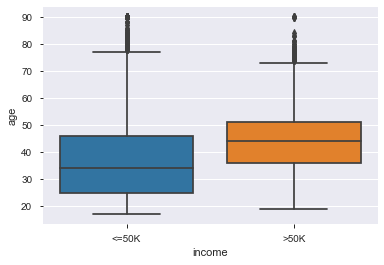

In [168]:
sns.boxplot(x='income',y='age', data=data)
plt.show()

https://www.kaggle.com/residentmario/bivariate-plotting-with-pandas

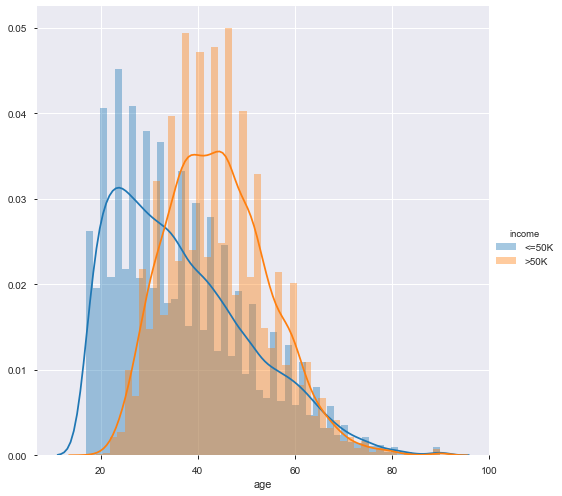

In [169]:
sns.FacetGrid(data,hue='income',size=7).map(sns.distplot,'age').add_legend()

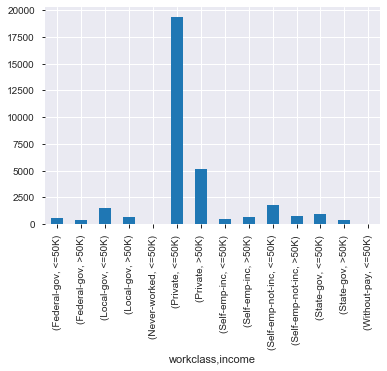

In [170]:
data.groupby(['workclass', 'income']).count()['age'].plot.bar(stacked=True)

### 2. Workclass 
- `Without-pay` , `Never-worked` did not even present in 1% of data set hence marking it as others - this class 100% falls under <=50K category of income
- One-Hot encoding

In [171]:
data['workclass'] = data['workclass'].replace(['Without-pay','Never-worked' ] , ['others','others'])

#doing onehot encoding 
column_name='workclass'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 3.Fnlwgt
- Normalizing it 

income
<=50K    AxesSubplot(0.125,0.125;0.775x0.755)
>50K     AxesSubplot(0.125,0.125;0.775x0.755)
Name: fnlwgt, dtype: object

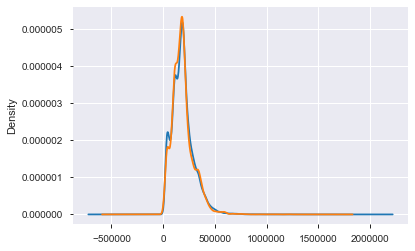

In [172]:
data.groupby('income').fnlwgt.plot(kind='kde')

With info from abouve graph and from Profiling report 
- we will normalize this column data from -1 to 1

In [173]:
#mean_val=data["fnlwgt"].mean()
#std_val=data["fnlwgt"].std()

min_val=data["fnlwgt"].min()
max_val=data["fnlwgt"].max()

data["fnlwgt"]=((data["fnlwgt"]-min_val)/(max_val-min_val))
#data["fnlwgt"]=((data["fnlwgt"]-mean_val)/std_val)

#### 4. Education


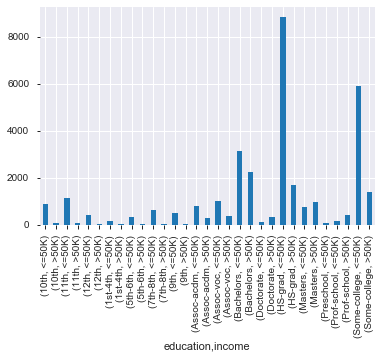

In [174]:
data.groupby(['education', 'income']).count()['age'].plot.bar(stacked=True)

In [175]:
data['education'].unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

In [176]:
data['education'] = data['education'].replace(['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','Assoc-acdm','Assoc-voc' ] 
                , ['below_high_school','below_high_school','below_high_school','below_high_school','below_high_school','below_high_school','above_high_school','above_high_school','Assoc','Assoc'])

#doing onehot encoding 
column_name='education'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 5. Education.num
- droping it as its covered in education column. Verified with `Phik` Correlations graph in profiling 

In [177]:
data.drop('education.num', axis=1, inplace=True)

### 6.marital.status

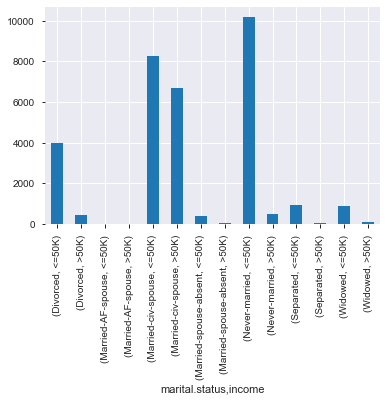

In [178]:
data.groupby(['marital.status', 'income']).count()['age'].plot.bar(stacked=True)

In [179]:
data['marital.status'] = data['marital.status'].replace(['Married-spouse-absent','Married-AF-spouse' ] , ['Married-xx','Married-xx'])

#doing onehot encoding 
column_name='marital.status'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 7.occupation

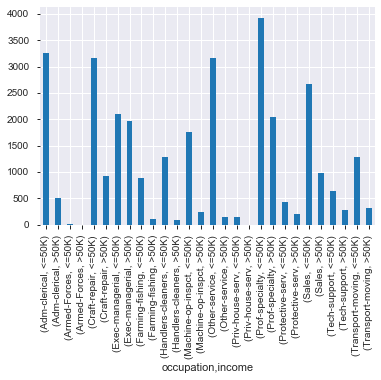

In [180]:
data.groupby(['occupation', 'income']).count()['age'].plot.bar(stacked=True)

In [181]:
data.occupation.value_counts()

Prof-specialty       5979
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: occupation, dtype: int64

In [182]:
data['occupation'] = data['occupation'].replace(['Armed-Forces','Priv-house-serv','Protective-serv' ] , ['Other-service','Other-service','Other-service'])

#doing onehot encoding
column_name='occupation'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 8. relationship

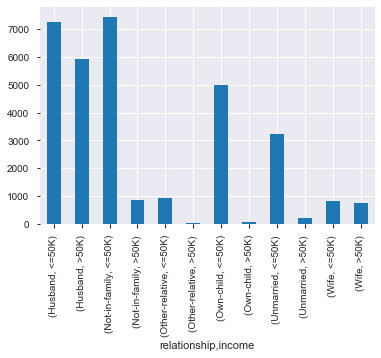

In [183]:
data.groupby(['relationship', 'income']).count()['age'].plot.bar(stacked=True)

In [184]:

#doing onehot encoding
column_name='relationship'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 9. race

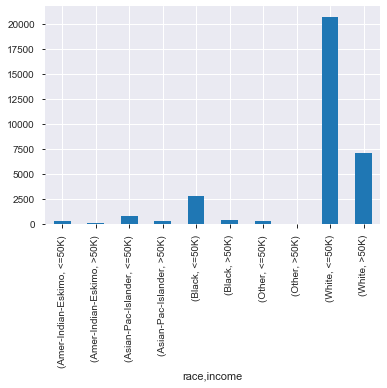

In [185]:
data.groupby(['race', 'income']).count()['age'].plot.bar(stacked=True)

In [186]:

#doing onehot encoding
column_name='race'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 10. sex

In [187]:
data['sex'] = data['sex'].map({'Male': 1, 'Female': 0})

### 11. capital.gain

Seems data is too much skewed, from the stats shown in profiling 
<br>
Hence converting it in to categorical Zero, Low, Medium, High, UltraHigh

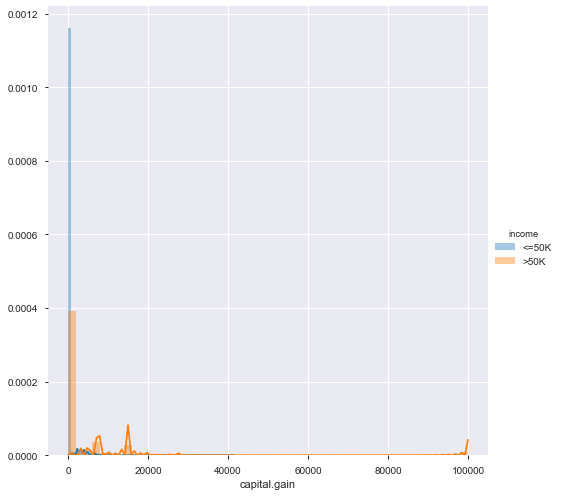

In [188]:
sns.FacetGrid(data,hue='income',size=7).map(sns.distplot,'capital.gain').add_legend()

In [189]:
bins = [-1,0, 5000, 10000, 20000, 150000]
labels =['Zero','Low','Medium','High','UltraHigh']    # 
data['capital.gain']=pd.cut(data['capital.gain'], bins,labels=labels)

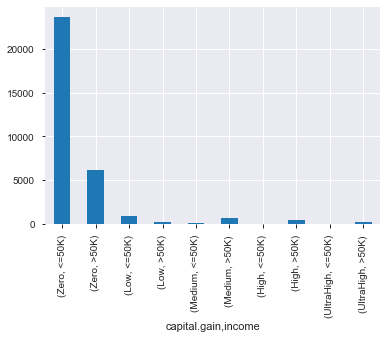

In [190]:
data.groupby(['capital.gain', 'income']).count()['age'].plot.bar(stacked=True)

In [191]:
#doing onehot encoding
column_name='capital.gain'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 12. capital.loss

Seems data is too much skewed, from the stats shown in profiling 
<br>
Hence converting it in to categorical Zero, Low, Medium, High, UltraHigh

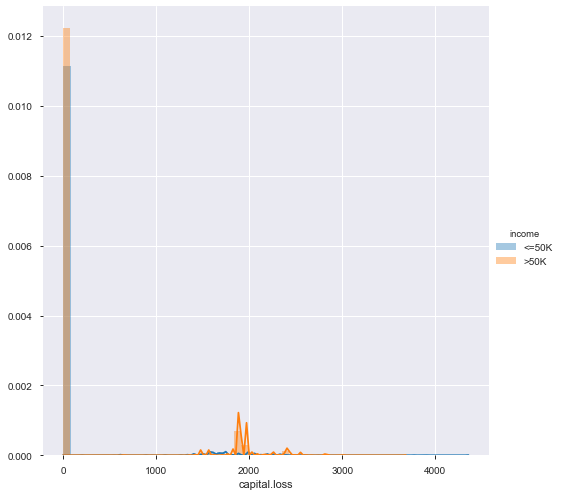

In [192]:
sns.FacetGrid(data,hue='income',size=7).map(sns.distplot,'capital.loss').add_legend()

In [193]:
bins = [-1,0, 1000, 2000, 3000, 5000]
labels =['Zero','Low','Medium','High','UltraHigh']    # 
data['capital.loss']=pd.cut(data['capital.loss'], bins,labels=labels)

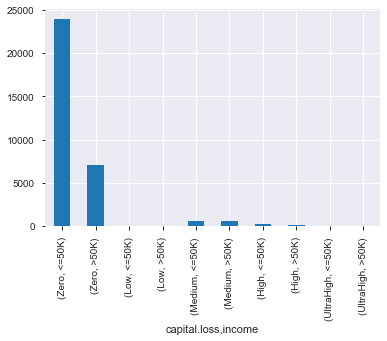

In [194]:
data.groupby(['capital.loss', 'income']).count()['age'].plot.bar(stacked=True)

In [195]:
#doing onehot encoding
column_name='capital.loss'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 13. Hours.per.week

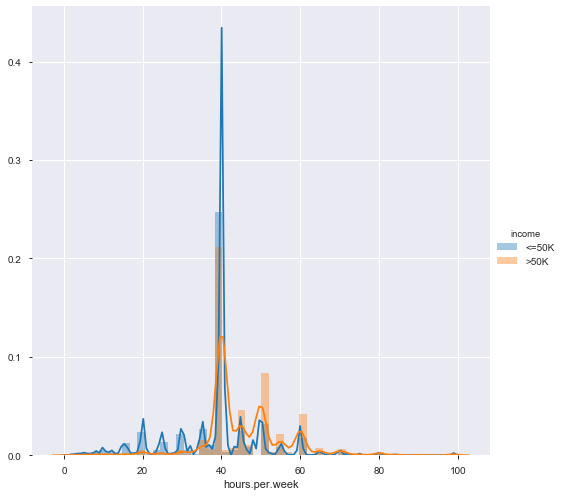

In [196]:
sns.FacetGrid(data,hue='income',size=7).map(sns.distplot,'hours.per.week').add_legend()

In [197]:
bins = [0,20, 35, 45, 60, 100]
labels =['Low','Medium','Normal','Overtime','owl']    # 
data['hours.per.week']=pd.cut(data['hours.per.week'], bins,labels=labels)

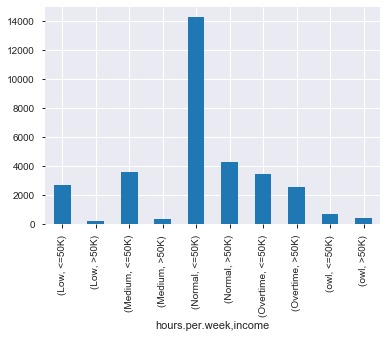

In [198]:
data.groupby(['hours.per.week', 'income']).count()['age'].plot.bar(stacked=True)

In [199]:
#doing onehot encoding
column_name='hours.per.week'
data=pd.concat([data,pd.get_dummies(data[column_name],prefix=column_name)],axis=1).drop([column_name],axis=1)

### 14. native.country

There are 42 unique values, of which 40 countries does not have 1% representaion. 
<br>
So keeping this study as US and NON-US study, making this variable as binary


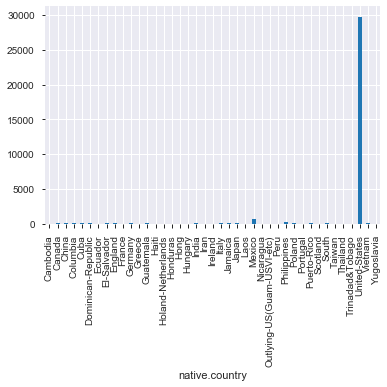

In [200]:
data.groupby(['native.country']).count()['age'].plot.bar(stacked=True)

In [201]:
data['native.country'][data['native.country'] != 'United-States']=0
data['native.country'][data['native.country'] == 'United-States']=1 


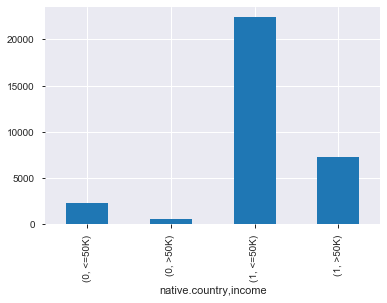

In [202]:
data.groupby(['native.country', 'income']).count()['age'].plot.bar(stacked=True)

<a id="datapreparation"></a>

## Step 3: Feature Engineering

Move [top](#top)

**Replace income variable with 1 or 0**

In [203]:
data['income'] = data['income'].map({'>50K': 1, '<=50K': 0})

In [205]:
data['income'].unique()

array([0, 1], dtype=int64)

In [204]:
data.head()

age    fnlwgt  sex native.country  income  workclass_Federal-gov  \
0   90  0.043987    0              1       0                      0   
1   82  0.081896    0              1       0                      0   
2   66  0.118021    0              1       0                      0   
3   54  0.086982    0              1       0                      0   
4   41  0.171404    0              1       0                      0   

   workclass_Local-gov  workclass_Private  workclass_Self-emp-inc  \
0                    0                  1                       0   
1                    0                  1                       0   
2                    0                  1                       0   
3                    0                  1                       0   
4                    0                  1                       0   

   workclass_Self-emp-not-inc  ...  capital.loss_Zero  capital.loss_Low  \
0                           0  ...                  0                 0   
1                           0  ...                  0                 0   
2                           0  ...                  0                 0   
3                           0  ...                  0                 0   
4                           0  ...                  0                 0   

   capital.loss_Medium  capital.loss_High  capital.loss_UltraHigh  \
0                    0                  0                       1   
1                    0                  0                       1   
2                    0                  0                       1   
3                    0                  0                       1   
4                    0                  0                       1   

   hours.per.week_Low  hours.per.week_Medium  hours.per.week_Normal  \
0                   0                      0                      1   
1                   1                      0                      0   
2                   0                      0                      1   
3                   0                      0                      1   
4                   0                      0                      1   

   hours.per.week_Overtime  hours.per.week_owl  
0                        0                   0  
1                        0                   0  
2                        0                   0  
3                        0                   0  
4                        0                   0  

[5 rows x 64 columns]

### Extract X and Y colummns

In [206]:
label_col = data['income'] 
feature_col = data.drop(['income'],axis=1)

### Test Train Split - startified


In [207]:
from sklearn.model_selection import train_test_split

In [208]:
#Constants
TEST_RATIO=0.33
RANDOM_STATE=101

In [209]:
x_train, x_test, y_train, y_test = train_test_split(feature_col, label_col,
                                                    test_size=TEST_RATIO,
                                                    random_state=RANDOM_STATE,
                                                    stratify=label_col)

<a id="buildingmodel"></a>
## Step 4: Building Model

Move [top](#top)

1. Gaussian Naive Bayes
2. Logistic Regression

In [211]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred_gnb=gnb.predict(x_test)

In [212]:

print("Accuracy: ", accuracy_score(y_test,y_pred_gnb))

Accuracy:  0.7897187558204507


### Multinomial NB

In [213]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred_mnb=mnb.predict(x_test)

In [214]:
print("Accuracy: ", accuracy_score(y_test,y_pred_mnb))

Accuracy:  0.821754516669771


In [215]:
# examine the class distribution of the testing set
y_test.value_counts()

0    8151
1    2587
Name: income, dtype: int64

**Logistic Regression Model**

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

log_model = LogisticRegression()

log_model.fit(x_train, y_train)

predictions = log_model.predict(x_test)


In [217]:
print("Accuracy score of logistic regression {0}".format(classification_report(y_test, predictions)))

Accuracy score of logistic regression               precision    recall  f1-score   support

           0       0.88      0.94      0.91      8151
           1       0.75      0.59      0.66      2587

    accuracy                           0.85     10738
   macro avg       0.81      0.76      0.78     10738
weighted avg       0.85      0.85      0.85     10738



<a id="evaluation"></a>
## Step 5: Evaluation of model
Move [top](#top)

### Confusion Matrix for Gaussian NB
- First argument is true values, second argument is predicted values this produces a 2x2 numpy array (matrix)

In [63]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred_gnb))
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred_gnb).ravel()
(TN, FP, FN, TP)

[[6312 1839]
 [ 419 2168]]


(6312, 1839, 419, 2168)

- True Positives (TP):  1314 
- True Negatives (TN):  3827
- False Positives (FP): 1113 (a Type I error)
- False Negatives (FN): 254 (a Type II error)


In [64]:
# print the first 25 true and predicted responses
print('True', y_test.values[0:25])
print('Pred', y_pred_gnb[0:25])

True [0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]
Pred [0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0]


 ##### Metrics computed from a confusion matrix
 ##### Classification Accuracy: Overall, how often is the classifier correct?

In [65]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_gnb))

0.7897187558204507
0.7897187558204507


##### Classification Error: Overall, how often is the classifier incorrect
##### Also known as "Misclassification Rate"

In [66]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_gnb))

0.21028124417954927
0.2102812441795493


### Sensitivity:
- When the actual value is positive, how often is the prediction correct

In [67]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, y_pred_gnb))

0.8380363355237727
0.8380363355237727


### Specificity: 
- When the actual value is negative, how often is the prediction correct

In [68]:
specificity = TN / (TN + FP)
print(specificity)

0.7743835112256164


##### False Positive Rate: When the actual value is negative, how often is the prediction incorrect

In [69]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.2256164887743835
0.22561648877438356


##### Precision: When a positive value is predicted, how often is the prediction correct

In [70]:
precision = TP / float(TP + FP)
print(precision)
print(metrics.precision_score(y_test, y_pred_gnb))

0.5410531569752932
0.5410531569752932


### Receiver Operating Characteristic (ROC) Curves for Gaussian NB
- ROC curve can help you to choose a threshold that balances sensitivity and specificity in a way that makes sense for particular context

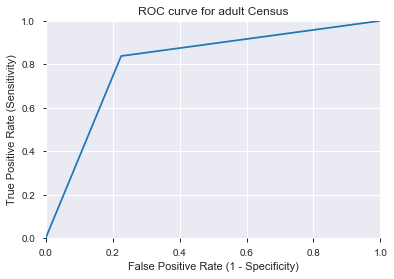

In [71]:
# First argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_gnb)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adult Census')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

In [72]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [73]:
evaluate_threshold(0.5)

Sensitivity: 0.8380363355237727
Specificity: 0.7743835112256165


In [74]:
evaluate_threshold(0.3)

Sensitivity: 0.8380363355237727
Specificity: 0.7743835112256165


### AUC for Gaussian NB

- AUC is the percentage of the ROC plot that is underneath the curve
- AUC is useful as a single number summary of classifier performance
- Higher value = better classifier
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
- AUC is useful even when there is high class imbalance (unlike classification accuracy)
- Fraud case
- Null accuracy almost 99%


In [75]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_gnb))

0.8062099233746945


In [76]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()
cross_val_score(logreg, feature_col, label_col, cv=10, scoring='roc_auc').mean()

0.8416970278589023

### Confusion Matrix for Multinomial NB
- First argument is true values, second argument is predicted values this produces a 2x2 numpy array (matrix)


In [77]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred_mnb))
TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_pred_mnb).ravel()
(TN, FP, FN, TP)

[[6897 1254]
 [ 660 1927]]


(6897, 1254, 660, 1927)

- True Positives (TP):  1188 
- True Negatives (TN):  4182
- False Positives (FP): 758 (a Type I error)
- False Negatives (FN): 380 (a Type II error)

In [78]:
# print the first 25 true and predicted responses
print('True', y_test.values[0:25])
print('Pred', y_pred_mnb[0:25])

True [0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0]
Pred [0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0]


##### Metrics computed from a confusion matrix
##### Classification Accuracy: Overall, how often is the classifier correct?

In [79]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_mnb))

0.821754516669771
0.821754516669771


Classification Error: Overall, how often is the classifier incorrect
Also known as "Misclassification Rate"

In [80]:

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_mnb))

0.1782454833302291
0.17824548333022905


### Sensitivity:
When the actual value is positive, how often is the prediction correct

In [81]:
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred_mnb))

0.7448782373405489
0.7448782373405489


### Specificity: 
- When the actual value is negative, how often is the prediction correct

In [82]:
specificity = TN / (TN + FP)
print(specificity)

0.8461538461538461


False Positive Rate: When the actual value is negative, how often is the prediction incorrect
false_positive_rate = FP / float(TN + FP)

In [83]:
print(false_positive_rate)
print(1 - specificity)

0.2256164887743835
0.15384615384615385


### Precision: 
- When a positive value is predicted, how often is the prediction correct

In [84]:
precision = TP / float(TP + FP)
print(precision)
print(metrics.precision_score(y_test, y_pred_mnb))

0.6057843445457404
0.6057843445457404


### Receiver Operating Characteristic (ROC) Curves for Multinomial NB

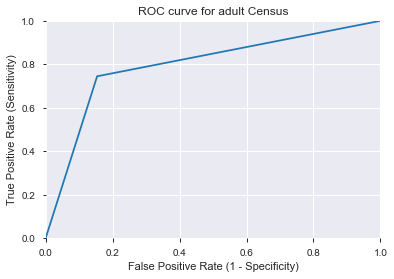

In [85]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_mnb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adult Census')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

### Define a function that accepts a threshold and prints sensitivity and specificity

In [125]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [126]:
evaluate_threshold(0.5)

Sensitivity: 0.7576530612244898
Specificity: 0.8465587044534413


In [127]:
evaluate_threshold(0.3)

Sensitivity: 0.7576530612244898
Specificity: 0.8465587044534413


<a id="decisionboundary"></a>

## Step 6: Decision Boundary

Move [top](#top)


In [ ]:
# Initializing classifier
logreg = LogisticRegression()
# Fit the classifier with the data
logreg.fit(X,y)

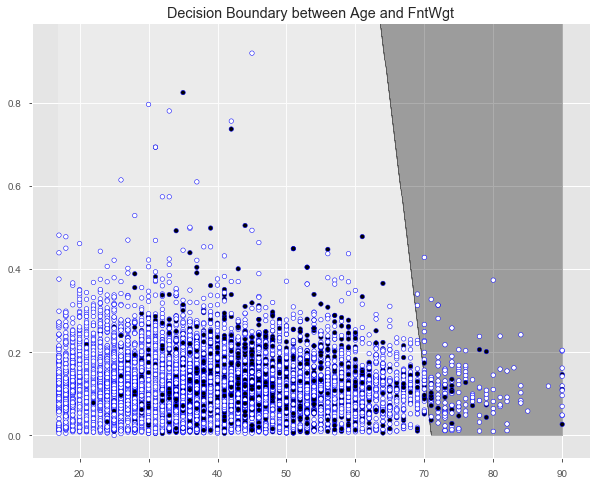

In [382]:
x_min, x_max = x_train['age'].min(), x_train['age'].max()
y_min, y_max = x_train['fnlwgt'].min(), x_train['fnlwgt'].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

f, axarr = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10, 8))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr.contourf(xx, yy, Z, alpha=0.35)
axarr.scatter(x_test['age'], x_test['fnlwgt'], c=y_test, s=20, edgecolors='b')
axarr.set_title("Decision Boundary between Age and FntWgt")

plt.show()